# Projet : Evaluation of the severity of a road accident

# Loading data and importing libraries

In [2]:
# Import the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from IPython.display import display
import graphviz

In [27]:
# Load the data
data_csv = pd.read_csv('rapports-accident-2020.csv')
# Display the dataset
data_csv.head()

,AN,NO_SEQ_COLL,DT_ACCDN,HR_ACCDN,JR_SEMN_ACCDN,gravite,NB_MORTS,NB_BLESSES_GRAVES,NB_BLESSES_LEGERS,NB_VICTIMES_TOTAL,...,nb_tous_autobus_minibus,nb_bicyclette,nb_cyclomoteur,nb_motocyclette,nb_taxi,nb_urgence,nb_motoneige,nb_VHR,nb_autres_types,nb_veh_non_precise
0,2020,2020 _ 1,2020-05-09,09:00:00-09:59:00,SA,Léger,0,0,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2020,2020 _ 2,2020-02-07,11:00:00-11:59:00,VE,Dommages matériels seulement,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2020,2020 _ 3,2020-06-01,12:00:00-12:59:00,LU,Dommages matériels seulement,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2020,2020 _ 4,2020-06-01,14:00:00-14:59:00,LU,Dommages matériels seulement,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2020,2020 _ 5,2020-11-26,07:00:00-07:59:00,JE,Grave,0,1,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Dataset pre-processing


## First analyse of dataset

In [28]:
# Size of dataset
n_obs, n_attr = data_csv.shape
print("The dataset contains", n_obs,"observations and", n_attr,"attributes.")

# Creating a copy of the dataframe that we will use later
df_data = data_csv.copy()

# Removal of variables not relevant to our analysis
df_data.drop(['AN','NO_SEQ_COLL','NB_MORTS','NB_BLESSES_GRAVES','NB_BLESSES_LEGERS','NB_VICTIMES_TOTAL',
               'NB_DECES_PIETON','NB_BLESSES_PIETON', 'NB_VICTIMES_PIETON','NB_DECES_MOTO','NB_BLESSES_MOTO','NB_VICTIMES_MOTO', 'NB_DECES_VELO',
               'NB_BLESSES_VELO','NB_VICTIMES_VELO', 'NO_CIVIQ_ACCDN','SFX_NO_CIVIQ_ACCDN','RUE_ACCDN','ACCDN_PRES_DE','CD_PNT_CDRNL_ROUTE',
               'NB_METRE_DIST_ACCD','CD_PNT_CDRNL_REPRR','CD_SIT_PRTCE_ACCDN','BORNE_KM_ACCDN'], axis=1, inplace=True)

The dataset contains 95088 observations and 60 attributes.


In [29]:
# Definition of qualitative and quantitative variabless
for col in df_data:
  if col.startswith('CD_') or col.startswith('NO_') or col.startswith('TP_'): # CD_ attributes correspond to codes and not quantitative variables
    df_data[col] = df_data[col].astype(str).replace('nan',np.nan)

df_data.dtypes

,0
DT_ACCDN,object
HR_ACCDN,object
JR_SEMN_ACCDN,object
gravite,object
NB_VEH_IMPLIQUES_ACCDN,float64
CD_MUNCP,object
REG_ADM,object
MRC,object
TP_REPRR_ACCDN,object
NO_ROUTE,object


In [30]:
# Configuring certain attributes

#  Month extraction
df_data['MOIS_ACCDN'] = pd.DatetimeIndex(df_data['DT_ACCDN']).month_name()
df_data.drop(['DT_ACCDN'], axis=1, inplace=True)
# New categories for GRAVITY
df_data.replace({'gravite': {'Dommages matériels seulement':'Dommages_materiels', 'Dommages matériels inférieurs au seuil de rapportage':'Dommages_materiels','Léger': "Leger", 'Grave': 'Grave','Mortel': 'Mortel'} },
                               inplace = True)

# New categories TP_REPRR_ACCDN
df_data.replace({'TP_REPRR_ACCDN': {'1.0':'Intersection', '2.0':'Autre_repere','0.0': "Autre_repere"} },
                               inplace = True)

# Add information about the type of accident (Creation of a new attribute)
code_collision_objet = [*range(38,59,1)]
code_collision_animal = [35,36,37]
code_collision_personne = [32,33]
code_collision_sanscollision = [*range(71,99,1)]

def category_genre_accdn(s):
  if s == 'nan' or s != np.nan:
    return "Non_precise"
  elif int(float(s)) in code_collision_objet:
    return "Collision_objet"
  elif int(float(s)) in code_collision_animal:
          return "Collision_animal"
  elif int(float(s)) in code_collision_personne:
          return "Collision_personne"
  elif int(float(s)) in code_collision_sanscollision:
          return "Sans_collision"
  else:
    return "Non_precise"

df_data['CD_GENRE_ACCDN_CAT'] = df_data['CD_GENRE_ACCDN'].apply(category_genre_accdn)


## Missing data analysis

In [31]:
# Calculation of the number of missing data by attributes
def get_nan_df(df):
  '''
  Function to calculate the number and rate of missing data
  in a dataframe

  INPUT
  -----
  df : dataframe

  OUTPUT
  -----
  dataframe with list of attributes ('attribute'), number of missing data ('nan_counts')
  and missing data rate for the attribute ('nan_rate)
  '''
  col_names, nan_count, nan_rate = [], [], []
  for col in df.columns:
    col_names.append(col)
    count_nan = df[col].isna().sum()
    nan_count.append(count_nan)
    nan_rate.append(count_nan/df[col].shape[0])

  df_nan = pd.DataFrame(list(zip(col_names, nan_count, nan_rate)), columns=['attribute', 'nan_counts', 'nan_rate'])
  return df_nan.sort_values('nan_rate',ascending=False).reset_index(drop=True)

df_nan = get_nan_df(df_data)
df_nan

,attribute,nan_counts,nan_rate
0,CD_ZON_TRAVX_ROUTR,92743,0.975339
1,CD_POSI_ACCDN,73835,0.776491
2,CD_ETAT_CHASS,72915,0.766816
3,NO_ROUTE,59831,0.629217
4,TP_REPRR_ACCDN,43600,0.458523
5,VITESSE_AUTOR,15604,0.164101
6,CD_LOCLN_ACCDN,5526,0.058115
7,CD_CONFG_ROUTE,4559,0.047945
8,CD_COND_METEO,1351,0.014208
9,CD_ECLRM,1325,0.013934


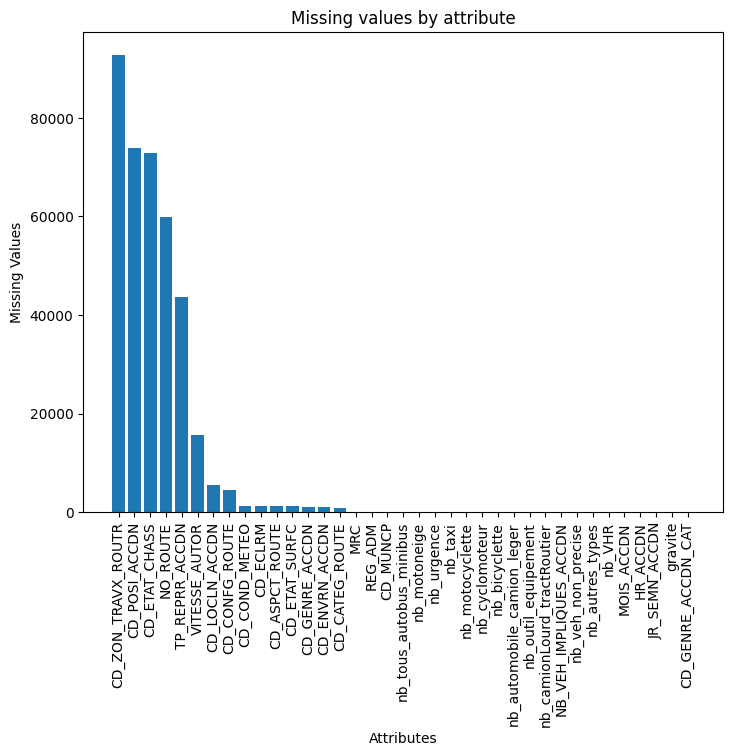

In [32]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(df_nan['attribute'],df_nan['nan_counts'])
plt.xticks(rotation=90)
ax.set_ylabel('Missing Values')
ax.set_xlabel('Attributes')
ax.set_title('Missing values by attribute')
plt.show()

### Case "Too much missing data": Deletion

In [33]:
# Removing attributes with more than 50% missing data
NAN_RATE_MAX = 0.5
attr_many_nan = list(df_nan.loc[df_nan['nan_rate'] > NAN_RATE_MAX, 'attribute'])
print('Attributes with more than 50% missing data are : ',attr_many_nan)
df_data.drop(attr_many_nan, axis=1, inplace=True)
df_data.dtypes

Attributes with more than 50% missing data are :  ['CD_ZON_TRAVX_ROUTR', 'CD_POSI_ACCDN', 'CD_ETAT_CHASS', 'NO_ROUTE']


,0
HR_ACCDN,object
JR_SEMN_ACCDN,object
gravite,object
NB_VEH_IMPLIQUES_ACCDN,float64
CD_MUNCP,object
REG_ADM,object
MRC,object
TP_REPRR_ACCDN,object
VITESSE_AUTOR,float64
CD_GENRE_ACCDN,object


In [34]:
# Delete accidents for which we have less than 33% of the information
ROW_NAN_RATE = 0.33
percent_row = df_data.count(axis=1)/ len(df_data.columns)
index_row = percent_row[percent_row < ROW_NAN_RATE].index
print(index_row)
if len(index_row) > 0:
    for i in range(len(index_row)):
        df_data.drop([index_row[i]], inplace=True)
df_data.shape

Index([5492, 11446, 12644, 41468, 41772, 46627], dtype='int64')


(95082, 33)

### Case "Some data missing": Filling

In [35]:
gb = df_data.groupby('gravite')
test = [gb.get_group(x) for x in gb.groups]
test[1].head()
test_2 = pd.concat(test, axis=0)
test_2.shape

(95082, 33)

In [36]:
def fill_missing_values(df):
  '''
  Function to replace missing data in a dataframe

  INPUT
  -----
  df : dataframe

  OUTPUT
  -----
  dataframe filled with median value for quantitative attributes and highest frequency value
  for categorical attributes
  '''
  for col in df.columns:
    if df[col].dtype == 'float64':
      df.fillna({col: df[col].median()}, inplace=True)
    elif df[col].dtype == 'object':
      df.fillna({col: df[col].mode()[0]}, inplace=True)
  return df


def fill_missing_values_by_cat(df, output='gravite'):
  '''
  Function to replace missing data in a dataframe with according to the category of the output variable

  INPUT
  -----
  df : dataframe
  output :  column containing categories

  OUTPUT
  -----
  dataframe filled with the median value for quantitative attributes and the highest frequency value
  for categorical attributes according to the observation class
  '''
  df_category = df_data.groupby(output)
  df_by_output = [df_category.get_group(x) for x in df_category.groups]
  L = []
  for df_group in df_by_output:
    d = df_group.copy()
    L.append(fill_missing_values(d))

  df = pd.concat(L, axis=0)
  return df

df_data = fill_missing_values(df_data) # Finally, we will not use the filling according to the class because the results are less good.
get_nan_df(df_data)


,attribute,nan_counts,nan_rate
0,HR_ACCDN,0,0.0
1,CD_COND_METEO,0,0.0
2,MOIS_ACCDN,0,0.0
3,nb_veh_non_precise,0,0.0
4,nb_autres_types,0,0.0
5,nb_VHR,0,0.0
6,nb_motoneige,0,0.0
7,nb_urgence,0,0.0
8,nb_taxi,0,0.0
9,nb_motocyclette,0,0.0


## Outlier Data Analysis

In [40]:
# HERE the detection is biased. I don't think it's outlier.
# On the contrary, they are probably indicative of an accident
# In any case, trees are robust to outliers

def compute_iqr(x):
  '''
  Function to calculate the interquartile range

  INPUT
  -----
  x : a column corresponding to a column of a dataframe

  OUTPUT
  -----
  iqr : interquartile range
  '''
  return np.subtract(*np.percentile(x, [75, 25]))

def check_outliers(df):
  '''
  Function applying the IQR method for outlier detection
  Any value outside the value range [Q1 - 1.5*IQR; Q3 + 1.5*IQR]
  is considered an outlier.

  INPUT
  -----
  df : A dataframe

  OUTPUT
  -----
  df_outliers : Dataframe with the list of attributes ('attributes')
                and the number of data considered outliers ('n_outliers')
  '''
  numerical_col = df.select_dtypes(include="float64")
  iqr = numerical_col.apply(compute_iqr)
  df_iqr = pd.DataFrame({'col':iqr.index, 'IQR':iqr.values})
  col_names, n_outliers = [], []
  for col in numerical_col:
    iqr_value_col = df_iqr[df_iqr['col'] == col]['IQR'].values[0]
    #if iqr_value_col != 0:
    Q1, Q3 = pd.DataFrame(df[col].quantile([0.25,0.75])).values[0][0], pd.DataFrame(df[col].quantile([0.25,0.75])).values[1][0]
    n_outliers.append(numerical_col[col][~numerical_col[col].between(Q1-1.5*iqr_value_col, Q3+1.5*iqr_value_col)].count())
    #else :
      #n_outliers.append(0)
    col_names.append(col)

  df_outliers = pd.DataFrame(list(zip(col_names, n_outliers)), columns=['attribute', 'n_outliers'])
  return df_outliers.sort_values('n_outliers',ascending=False).reset_index(drop=True)

check_outliers(df_data)

,attribute,n_outliers
0,nb_camionLourd_tractRoutier,11315
1,nb_veh_non_precise,4812
2,nb_urgence,2040
3,nb_motocyclette,1990
4,nb_outil_equipement,1910
5,nb_bicyclette,1645
6,nb_tous_autobus_minibus,1136
7,NB_VEH_IMPLIQUES_ACCDN,1065
8,nb_automobile_camion_leger,810
9,nb_taxi,687


## Correlated Data

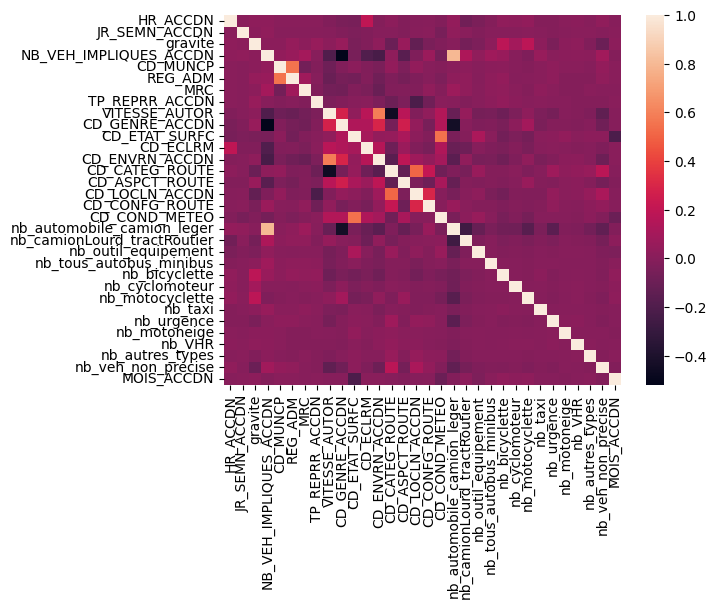

In [41]:
# Evaluation of the correlation between attributes

corr_df = df_data.copy()
enc = LabelEncoder()
for col in corr_df.columns:
  if corr_df[col].dtype == 'object':
    corr_df[col] = enc.fit_transform(corr_df[col]) # Encoding for categorical data

corr = corr_df.iloc[:, :-1].corr()
# Heatmap to visualize correlations
sns.heatmap(corr, xticklabels=corr.columns,yticklabels=corr.columns)
plt.show()

# Model Development

## Check the balance of the classes
We notice in the histogram below that the classes are greatly unbalanced. Indeed, the class of accidents "Material_damage" is dominant compared to the others: 70,000 accidents against ~19,000 "Slight" accidents then the rest is shared between "Serious" and "Fatal" accidents.

To compensate for this imbalance, we will use a weighting in our models to rebalance our classes. Indeed, our objective is not only to predict the severity of the accident (in which case we would risk predicting in the vast majority of cases an accident with material damage) but also to clearly highlight the characteristics of each type of accident.

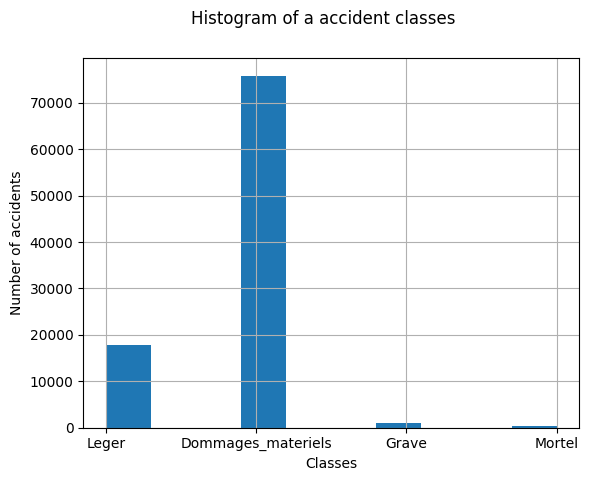

In [42]:
# A histogram to assess the balance between classes
class_hist = df_data["gravite"].hist()
plt.suptitle("Histogram of a accident classes")
plt.ylabel("Number of accidents")
plt.xlabel("Classes")
plt.show()

## Sets d'Entrainement/Test

In [43]:
from sklearn import preprocessing
def split_dataset(df, test_size, output_col='gravite', encoding='OneHot', set_seed=None):
  '''
  Function to split the dataset into training set and test set.

  INPUTS
  -----
  df : A dataframe
  test_size : The % size of the test set
  output_col : the column corresponding to the output variable
  encoding : 'None' for no encoding. 'Onehot' for one-hot encoding. 'LabelEncoder' for digital encoding.
  set_seed : Seed allowing the reproducibility of the result

  OUTPUTS
  -----
  X : dataframe containing all predictors
  Y : dataframe containing only the output variable
  X_train : training dataframe containing the predictors
  Y_train : training dataframe containing the output variable
  X_test : test dataframe containing the predictors
  Y_test : test dataframe containing the output variable
  '''
  if encoding == 'LabelEncoder':
    cat_col = df.select_dtypes(include="object")
    Label_encoder = preprocessing.LabelEncoder()
    for col in cat_col:
      if col != output_col:
        df[col] = Label_encoder.fit_transform(df[col])

  Y = df[output_col]
  X = df.loc[:, df.columns != output_col]

  if encoding == 'OneHot':
    X = pd.get_dummies(X,drop_first=True)

  # Splitting the dataset into training and testing sets
  if set_seed is not None:
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = test_size, random_state=set_seed)
  else:
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = test_size)

  return X, Y, X_train, X_test, Y_train, Y_test

X, Y, X_train, X_test, Y_train, Y_test = split_dataset(df_data, 0.30, 'gravite',encoding='OneHot', set_seed=204)

## Decision Tree

In [44]:
# Performing cross-validation to obtain the optimal tree depth
kf = KFold(n_splits=5)

depth = []

for i in range(2,10,1):
  print("... CV with a max depth of =", i,"...")
  decision_tree = tree.DecisionTreeClassifier(criterion = 'gini', max_depth=i, min_samples_leaf=1, class_weight='balanced',random_state=2)
  # Perform 5-fold cross validation
  scores = cross_val_score(decision_tree,X,Y, cv=kf, scoring='precision_micro',n_jobs=4)
  depth.append((i,scores.mean()))
print("Done.")

... CV with a max depth of = 2 ...
... CV with a max depth of = 3 ...
... CV with a max depth of = 4 ...
... CV with a max depth of = 5 ...
... CV with a max depth of = 6 ...
... CV with a max depth of = 7 ...
... CV with a max depth of = 8 ...
... CV with a max depth of = 9 ...
Done.


In [45]:
depth_score = pd.DataFrame(depth, columns=['depth', 'precision'])
print(depth_score)

   depth  precision
0      2   0.456312
1      3   0.573512
2      4   0.609924
3      5   0.607549
4      6   0.555173
5      7   0.524599
6      8   0.567645
7      9   0.525882


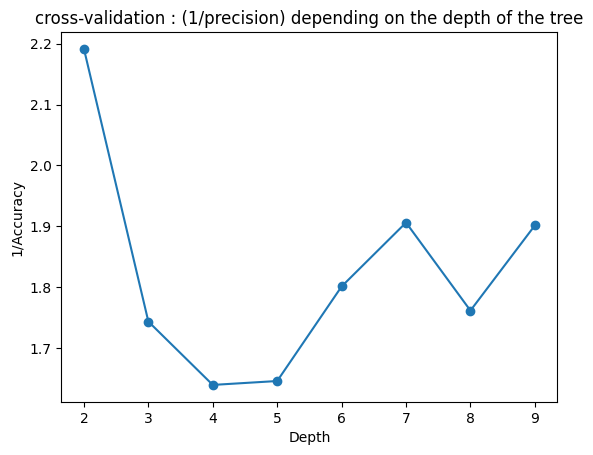

The optimal value for depth is 4 with a precision of : 60.99 %


In [47]:
# Displaying the cross-validation result
plt.plot(depth_score['depth'],1/depth_score['precision'], '-o')
plt.xlabel("Depth")
plt.ylabel("1/Accuracy")
plt.title("cross-validation : (1/precision) depending on the depth of the tree")
plt.show()

depth_optim, depth_optim_precision = depth_score[depth_score.precision == depth_score.precision.max()]['depth'].values[0], depth_score[depth_score.precision == depth_score.precision.max()]['precision'].values[0]

print("The optimal value for depth is", depth_optim,"with a precision of :", round(depth_optim_precision*100, 2), "%")


--------------- Learning performances -----------------------

Confusion Matrix: 



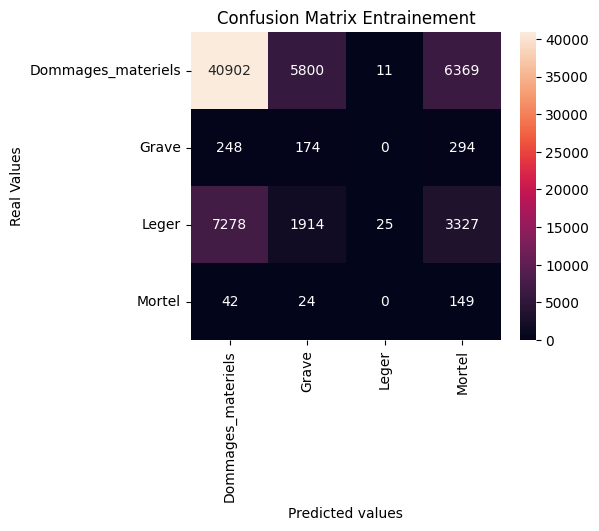

Precision :  61.98 %

Recall :  42.71 %


--------------- Validation performances ---------------------

Confusion Matrix: 



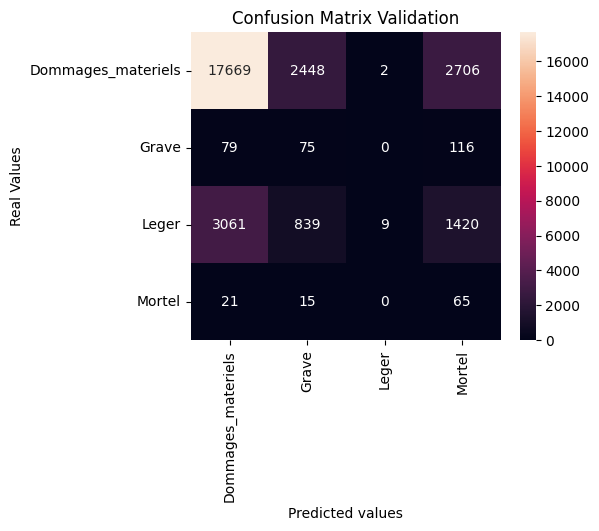

Precision :  62.46 %

Recall :  42.43 %



In [48]:
# Fitting an optimal classification tree and displaying training and validation results
best_model_tree = tree.DecisionTreeClassifier(criterion = 'gini', max_depth=depth_optim, min_samples_leaf=1, class_weight='balanced',random_state=200)
clf = best_model_tree.fit(X_train , Y_train)
class_levels = Y.unique()
class_levels[0],class_levels[1],class_levels[2],class_levels[3] = class_levels[1],class_levels[2],class_levels[0],class_levels[3]
print("\n--------------- Learning performances -----------------------\n")
# Predictions
Y_train_pred = clf.predict(X_train)
# Afficher les resultats
print("Confusion Matrix: \n")
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(Y_train, Y_train_pred), annot=True, fmt="g",  yticklabels=class_levels, xticklabels=class_levels)

plt.title('Confusion Matrix Entrainement')
plt.ylabel('Real Values')
plt.xlabel('Predicted values')
plt.show()
print ("Precision : ", round(accuracy_score(Y_train, Y_train_pred)*100,2), '%\n')
print ("Recall : ", round(recall_score(Y_train, Y_train_pred, average="macro")*100,2),'%\n')

print("\n--------------- Validation performances ---------------------\n")
# Predictions
Y_test_pred = clf.predict(X_test)
# Afficher les resultats
print("Confusion Matrix: \n")
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(Y_test, Y_test_pred), annot=True, fmt="g",  yticklabels=class_levels, xticklabels=class_levels)

plt.title('Confusion Matrix Validation')
plt.ylabel('Real Values')
plt.xlabel('Predicted values')
plt.show()
print ("Precision : ", round(accuracy_score(Y_test, Y_test_pred)*100,2),'%\n')
print ("Recall : ", round(recall_score(Y_test, Y_test_pred, average="macro")*100,2),'%\n')

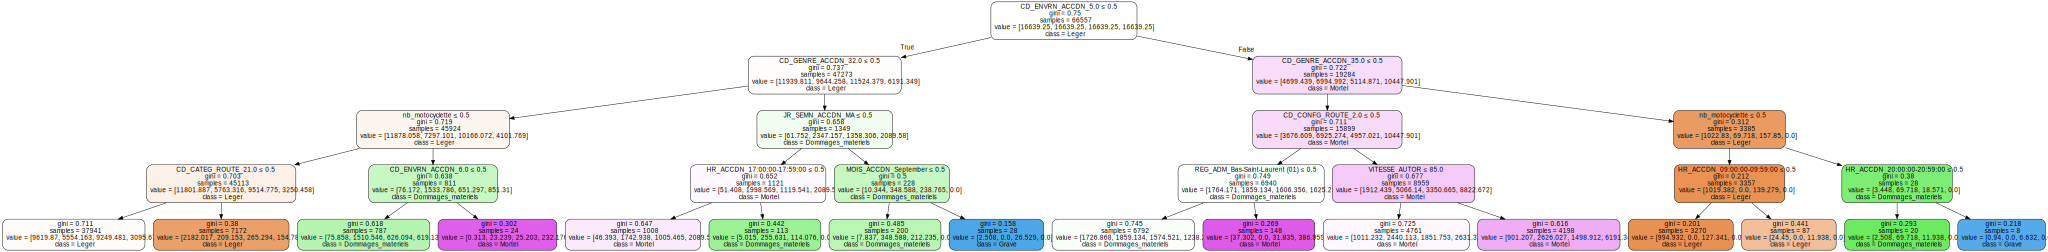

In [49]:
# Graphical display of the resulting decision tree
tree_img = tree.export_graphviz(clf,feature_names=X.columns.values,class_names=pd.unique(Y),filled=True, rounded=True,special_characters=True)
graph_tree = graphviz.Source(tree_img)
display(graph_tree)


In [50]:
# Save Image
graph_tree.render('decision_tree',format='png', view=False)

'decision_tree.png'

## Random Forest

In [51]:
'''
Performing cross-validation to obtain the optimal tree depth
and the optimal number of trees for Random Forest

--> CAN TAKE A LOT OF TIME
A long test was done with
param_grid = {
    'max_depth': [i for i in range(5,20,5)],
    'n_estimators': [i for i in range(100,600,100)]
}
Result :
The optimal value for depth is 15 with 300 trees and an accuracy of : 68.22 %

Given the calculation time which can be long, we have chosen
to set the maximum number of predictors to sqrt(total_number_of_predictors).
'''

# Creating a parameter grid for cross-validation
param_grid = {
    'max_depth': [15],
    'n_estimators': [300],
    'max_features': [int(np.sqrt(X.shape[1]))]
}
# Creating the Random Forest model
rf = RandomForestClassifier(criterion = "entropy", bootstrap=True, min_samples_leaf=1, class_weight='balanced',random_state=204)
# GridSearch with 5-fold cross-validation
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 5, n_jobs = 4, verbose=3)

In [52]:
# Adjustment on training data
grid_search.fit(X_train, Y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              criterion='entropy',
                                              random_state=204),
             n_jobs=4,
             param_grid={'max_depth': [15], 'max_features': [38],
                         'n_estimators': [300]},
             verbose=3)

In [53]:
# Display the obtained optimal parameters
best_rf_depth, ntrees, best_rf_nfeatures = grid_search.best_params_['max_depth'], grid_search.best_params_['n_estimators'], grid_search.best_params_['max_features']
rf_cv_best_accuracy = grid_search.best_score_
print("Random Forest : The optimal value for depth is", best_rf_depth,"with",ntrees,"trees and", best_rf_nfeatures,"predictors for an accuracy of :", round(rf_cv_best_accuracy*100, 2), "%")

Random Forest : The optimal value for depth is 15 with 300 trees and 38 predictors for an accuracy of : 70.18 %



--------------- Learning performances -----------------------

Confusion Matrix: 



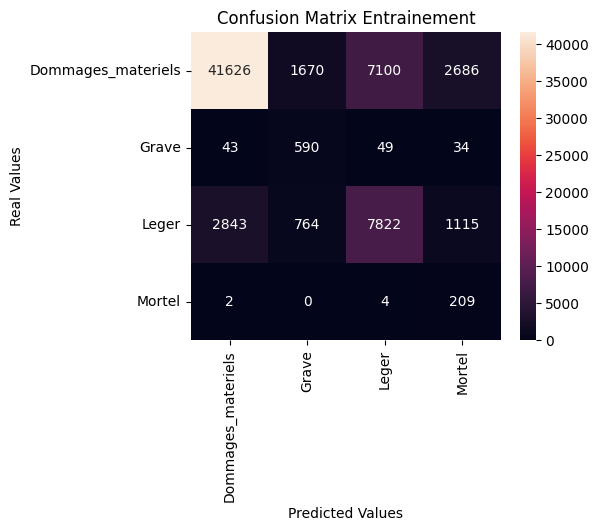

Precision :  75.49 %

Recall :  80.1 %


--------------- Validation performances ---------------------

Confusion Matrix: 



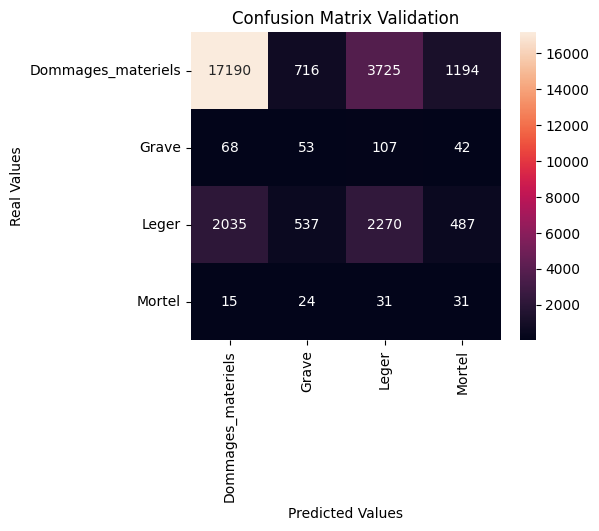

Precision :  68.52 %

Recall :  42.06 %



In [54]:
# Fitting an optimal Random Forest model and displaying training and validation results

best_rf = RandomForestClassifier(max_depth=best_rf_depth,n_estimators=ntrees, max_features= best_rf_nfeatures ,criterion = "entropy", bootstrap=True, min_samples_leaf=1, class_weight='balanced',random_state=204)
rf_clf = best_rf.fit(X_train , Y_train)
class_levels = Y.unique()
class_levels[0],class_levels[1],class_levels[2],class_levels[3] = class_levels[1],class_levels[2],class_levels[0],class_levels[3]
print("\n--------------- Learning performances -----------------------\n")
# Predictions
Y_train_pred = rf_clf.predict(X_train)
# Afficher les resultats
print("Confusion Matrix: \n")
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(Y_train, Y_train_pred), annot=True, fmt="g",  yticklabels=class_levels, xticklabels=class_levels)

plt.title('Confusion Matrix Entrainement')
plt.ylabel('Real Values')
plt.xlabel('Predicted Values')
plt.show()
print ("Precision : ", round(accuracy_score(Y_train, Y_train_pred)*100,2), '%\n')
print ("Recall : ", round(recall_score(Y_train, Y_train_pred, average="macro")*100,2),'%\n')

print("\n--------------- Validation performances ---------------------\n")
# Predictions
Y_test_pred = rf_clf.predict(X_test)
# Afficher les resultats
print("Confusion Matrix: \n")
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(Y_test, Y_test_pred), annot=True, fmt="g",  yticklabels=class_levels, xticklabels=class_levels)

plt.title('Confusion Matrix Validation')
plt.ylabel('Real Values')
plt.xlabel('Predicted Values')
plt.show()
print ("Precision : ", round(accuracy_score(Y_test, Y_test_pred)*100,2),'%\n')
print ("Recall : ", round(recall_score(Y_test, Y_test_pred, average="macro")*100,2),'%\n')